In [ ]:
#connect to google drive
# from google.colab import drive
# drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# from zipfile import ZipFile
# # extract file into google drive only excute once

# with ZipFile("/content/drive/MyDrive/comp3710A3SRCNN/ADNI_AD_NC_2D.zip", "r") as zipobj:
#     zipobj.extractall("/content/drive/MyDrive/comp3710A3SRCNN/ADNI_AD_NC_2D")

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [ ]:
# return data set(in batch size) from directory where each images belong to one 
# class is in the subdirectory 
# load data
def get_train():
    data_train = image_dataset_from_directory(
        "/content/drive/MyDrive/comp3710A3SRCNN/ADNI_AD_NC_2D/AD_NC/train", labels = "inferred", label_mode= None, image_size=(128, 128), batch_size=32, validation_split=0.3, subset="training", seed=1
    )

    train_dataset = data_train.map(lambda x: x / 255.0)
    print("train data: ", data_train)
    return train_dataset
train_data = get_train()

def get_validation():
    data_val = image_dataset_from_directory(
        "/content/drive/MyDrive/comp3710A3SRCNN/ADNI_AD_NC_2D/AD_NC/train", labels = "inferred", label_mode= None, image_size=(128, 128), batch_size=32, validation_split=0.3, subset="validation", seed=1
    )

    val_dataset = data_val.map(lambda x: x / 255.0)
    print("val data: ", data_val)
    return val_dataset
val_data = get_validation()


def get_test():
    data_test = image_dataset_from_directory(
        "/content/drive/MyDrive/comp3710A3SRCNN/ADNI_AD_NC_2D/AD_NC/test", labels = "inferred", label_mode= None, image_size=(128, 128), batch_size=32
    )

    test_dataset = data_test.map(lambda x: x / 255.0)
    print("test data: ", data_test)
    return test_dataset
test_data = get_test()

Found 21520 files belonging to 1 classes.
Using 15064 files for training.
train data:  <BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
Found 21520 files belonging to 1 classes.
Using 6456 files for validation.
val data:  <BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
Found 9000 files belonging to 1 classes.
test data:  <BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>


In [ ]:
""" rerurn img array representation of one image, return img array reprentation """
def get_img(data):
    # returns a dataset equivalent to iterate over with form of (data, label),
    imgs = data.take(1)
    iterator = iter(imgs)
    img_array = iterator.get_next()[0]
    return img_array

def resize_img(img_data, size):
    resized_img_data = tf.image.resize(img_data, [size, size], method='bicubic')
    resized_img_data = tf.image.resize(resized_img_data, (128, 128), method='bicubic')
    return resized_img_data

""" resize the all the train image data and display the first image"""
@tf.autograph.experimental.do_not_convert
def resize_img_flow(data, size):
    data = data.map(
        lambda x: (resize_img(x, size), x))
    return data
resized_train_data = resize_img_flow(train_data, 32)
resized_train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

resized_val = resize_img_flow(val_data, 32)
resized_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

resized_test = resize_img_flow(test_data, 32)
resized_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

----------
(None, 32, 32, 3)
(None, 128, 128, 3)
----------
(None, 32, 32, 3)
(None, 128, 128, 3)
----------
(None, 32, 32, 3)
(None, 128, 128, 3)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

In [ ]:
# buld model 
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras import Model


def get_model():
    height, width = 128, 128
    input_img = Input((height, width, 3))
    lay = Conv2D(64, (9,9), padding = 'same', activation= 'relu')(input_img)
    lay = Conv2D(32, (1,1), padding = 'same', activation= 'relu')(lay)
    lay = Conv2D(3, (5,5), padding = 'same', activation= 'relu')(lay)
    model = Model(inputs=input_img, outputs=lay)
    model.summary()
    return model


model = get_model()

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# loss function
loss_fun = MeanSquaredError()
optimizer_Adam = Adam(0.001)


model.compile(loss=loss_fun, optimizer=optimizer_Adam, metrics=['MeanSquaredError'])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# resized_train_data
# resized_val

<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

In [ ]:
epoch = 20
history = model.fit(resized_train_data, epochs=epoch, validation_data=resized_val)

Epoch 1/20
471/471 [==============================] - 38s 79ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/20
471/471 [==============================] - 38s 80ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/20
471/471 [==============================] - 38s 80ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/20
471/471 [==============================] - 37s 78ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/20
471/471 [==============================] - 37s 78ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/20
471/471 [==============================] - 37s 78ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/20
471/4

In [ ]:
# model.save_weights('/content/drive/MyDrive/comp3710A3SRCNN/model/modeH5_{}.h5'.format(epoch+245))


In [ ]:
model.load_weights('/content/drive/MyDrive/comp3710A3SRCNN/model/modeH5_245.h5')

original----------


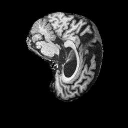

resized----------
----------
(32, 32, 3)
(128, 128, 3)


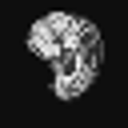

(128, 128, 3)
(1, 128, 128, 3)
----------predict----------


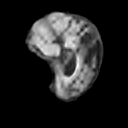

In [ ]:
# compare the result of original,resized and model predicted
def predict_comparion(test_ds):

    print("original----------")
    test_one_img_data = get_img(test_ds)
    test_img_one = array_to_img(test_one_img_data) 
    display(test_img_one)

    print("small image resized--------")
    small_img_data = tf.image.resize(test_one_img_data, [32, 32], method='bicubic')
    small_img = array_to_img(small_img_data) 
    display(small_img)

    print("resized----------")
    resized_img_array = resize_img(test_one_img_data, 32)
    resized_test_one_img = array_to_img(resized_img_array) 
    display(resized_test_one_img)
    print(resized_img_array.shape) #(128, 128, 3)
    resized_img_array = tf.expand_dims(resized_img_array, axis = 0) # for feed into model prediction
    print(resized_img_array.shape) # (1, 128, 128, 3)

    print("----------predict----------")
    predict_result_one_data = model.predict(resized_img_array)
    predict_img_one = array_to_img(predict_result_one_data[0])
    display(predict_img_one)

predict_comparion(test_data)

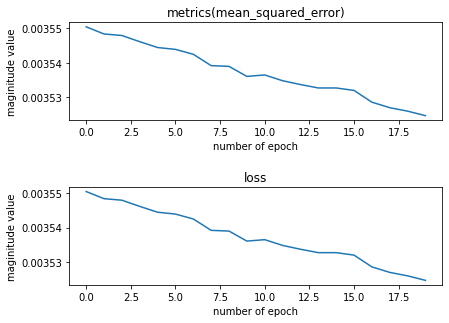

In [ ]:
import matplotlib.pyplot as plt

def make_plot(history, epoch):
  acc_list = history.history['mean_squared_error']
  loss_list = history.history['loss']

  x_epoch = [i for i in range(epoch)]

  fig = plt.figure()
  ax1 = fig.add_subplot(211)
  fig.tight_layout(h_pad=5)
  ax1.plot(x_epoch, acc_list, label='mean_squared_error')
  ax1.set_xlabel("number of epoch")
  ax1.set_ylabel("maginitude value")
  ax1.set_title("metrics(mean_squared_error)")
  ax2 = fig.add_subplot(212)
  ax2.plot(x_epoch, loss_list, label='loss')
  ax2.set_xlabel("number of epoch")
  ax2.set_ylabel("maginitude value")
  ax2.set_title("loss")
  plt.show()
make_plot(history, epoch)